In [3]:
import numpy as np
import string
import os
import time
import json
import matplotlib.pyplot as plt
from keras.datasets import mnist
from scipy.spatial import distance_matrix
import pickle
from IPython.display import clear_output

In [2]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

tr_x = []
for data in train_X:
    tr_x += [data.flatten()]
tr_x = np.array(tr_x)

te_x = []
for data in test_X:
    te_x += [data.flatten()]
te_x = np.array(te_x)

tr_y = train_y
te_y = test_y

In [3]:
def kernel_func_p(x, sigma, p = 1):
    return np.exp(-((x**p)/(p * sigma**p)))

def solve_alpha(K, y):
    return np.matmul(np.linalg.inv(K), y)

def create_y_matrix(y_train, num_digits):
    y_mat = np.zeros((len(y_train), num_digits))
    for i in range(len(y_train)):
        y_mat[i][y_train[i]] = 1
    return y_mat

def classification(predictions, y_test):
    preds = np.argmax(predictions, axis = 1)
    correct = 0
    for i, j in zip(preds, y_test):
        if i == j:
            correct += 1
    return 1 - (correct / len(y_test))
    
def prepare_data(train_X, train_y, test_X, test_y, num_train = 1000, num_test = 500, num_digits = 10):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    digits = range(num_digits)
    
    for i in range(len(train_X)):
        if train_y[i] in digits:
            X_train.append(train_X[i].flatten())
            y_train.append(train_y[i])
            
        if len(y_train) == num_train:
            break
            
    for i in range(len(test_X)):
        if test_y[i] in digits:
            X_test.append(test_X[i].flatten())
            y_test.append(test_y[i])
        
        if len(y_test) == num_test:
            break
    
    return X_train, y_train, X_test, y_test

def run_classification_kernel(train_X, train_y, test_X, test_y, num_digits = 10, num_train = 1000, num_test = 500, p = 1, sigma = 1):
    X_train, y_train, X_test, y_test = prepare_data(train_X, train_y, test_X, test_y, num_train, num_test, num_digits)
    
    D = distance_matrix(X_train, X_train)
    K = kernel_func_p(D, sigma * np.mean(D), p)
    
    y_matrix = create_y_matrix(y_train, num_digits)
    alpha = solve_alpha(K, y_matrix)
    
    D_test = distance_matrix(X_test, X_train)
    K_test = kernel_func_p(D_test, sigma * np.mean(D), p)
    
    predictions = np.matmul(K_test, alpha)
    
    return classification(predictions, y_test)

In [8]:
num_train = 2000
num_test = 500
errors = []

for num_digits in range(2, 11):
    errors.append(round(run_classification_kernel(train_X, train_y, test_X, test_y, num_digits, num_train, num_test), 5))

In [9]:
errors

[0.0, 0.008, 0.01, 0.012, 0.026, 0.03, 0.048, 0.058, 0.07]

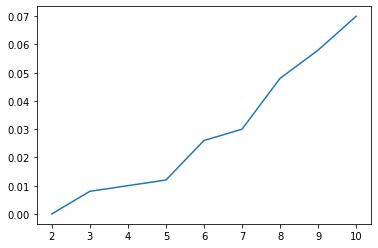

In [10]:
plt.plot(range(2, 11), errors)

In [40]:
num_train = 10000
num_test = 10000
num_digits = 10

X_train, y_train, X_test, y_test = prepare_data(train_X, train_y, test_X, test_y, num_train, num_test, num_digits)
    
# D = distance_matrix(X_train, X_train)
# D_test = distance_matrix(X_test, X_train)

errors = {}

for p in [2, 1, 1/2]:
    errors[p] = []
    for num_data in [100, 500, 1000, 2500, 5000, 10000]:
        D1 = D[:num_data, :num_data]
        K1 = kernel_func_p(D1, np.mean(D1), p)

        y_matrix1 = create_y_matrix(y_train[:num_data], num_digits)
        alpha = solve_alpha(K1, y_matrix1)

        D_test1 = D_test[:, :num_data]
        K_test1 = kernel_func_p(D_test1, np.mean(D1), p)

        predictions = np.matmul(K_test1, alpha)

        errors[p] += [classification(predictions, y_test)]

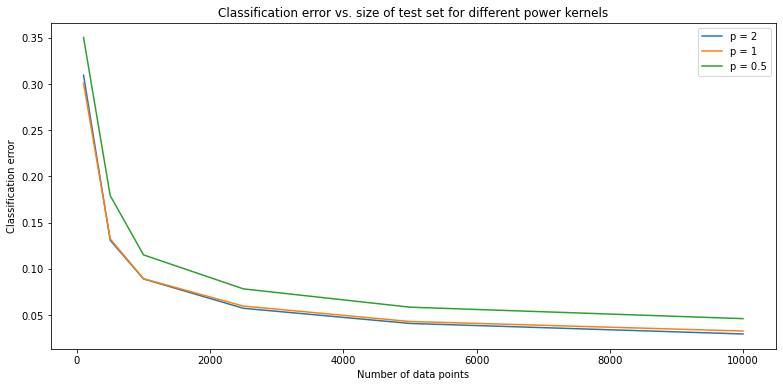

In [42]:
fig, axes = plt.subplots(figsize = (13, 6))
legend = []
for p in [2, 1, 1/2]:
    axes.plot([100, 500, 1000, 2500, 5000, 10000], errors[p])
    legend += [f'p = {p}']
axes.set_title('Classification error vs. size of test set for different power kernels')
axes.set_xlabel('Number of data points')
axes.set_ylabel('Classification error')
_ = axes.legend(legend)

In [43]:
errors

{2: [0.3095,
  0.13080000000000003,
  0.08899999999999997,
  0.05720000000000003,
  0.04079999999999995,
  0.02939999999999998],
 1: [0.30079999999999996,
  0.13229999999999997,
  0.08919999999999995,
  0.059599999999999986,
  0.04290000000000005,
  0.03259999999999996],
 0.5: [0.35029999999999994,
  0.17920000000000003,
  0.11499999999999999,
  0.07820000000000005,
  0.05840000000000001,
  0.04600000000000004]}

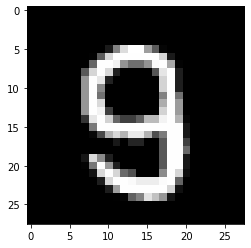

In [34]:
sample = 241
image = test_X[sample]
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.title = f'{test_y[i]}'
plt.show()

In [14]:
num_train = 10000
num_test = 2500
num_digits = 10

X_train, y_train, X_test, y_test = prepare_data(train_X, train_y, test_X, test_y, num_train, num_test, num_digits)

if os.path.exists('distance_matrix_train.pickle'):
    with open('distance_matrix_train.pickle', 'rb') as f:
        D = pickle.load(f)
else:
    D = distance_matrix(X_train, X_train)
    with open('distance_matrix_train.pickle', 'wb') as f:
        pickle.dump(D, f)

if os.path.exists('distance_matrix_test.pickle'):
    with open('distance_matrix_test.pickle', 'rb') as f:
        D_test = pickle.load(f)
else:
    D_test = distance_matrix(X_test, X_train)
    with open('distance_matrix_test.pickle', 'wb') as f:
        pickle.dump(D_test, f)

In [18]:
errors = {}
p_list = [3, 2, 1, 1/2, 1/3, 1/4, 1/5]
data_list = [100, 500, 1000, 2500, 5000, 10000]

for p in p_list:
    errors[p] = []

for num_data in data_list:
    for p in [3, 2, 1, 1/2, 1/3, 1/4, 1/5]:
        D1 = D[:num_data, :num_data]
        D_test1 = D_test[:, :num_data]
        
        K = kernel_func_p(D1, np.mean(D1), p)

        y_matrix = create_y_matrix(y_train[:num_data], num_digits)
        alpha = solve_alpha(K, y_matrix)

        K_test = kernel_func_p(D_test1, np.mean(D1), p)

        predictions = np.matmul(K_test, alpha)

        errors[p] += [classification(predictions, y_test)]

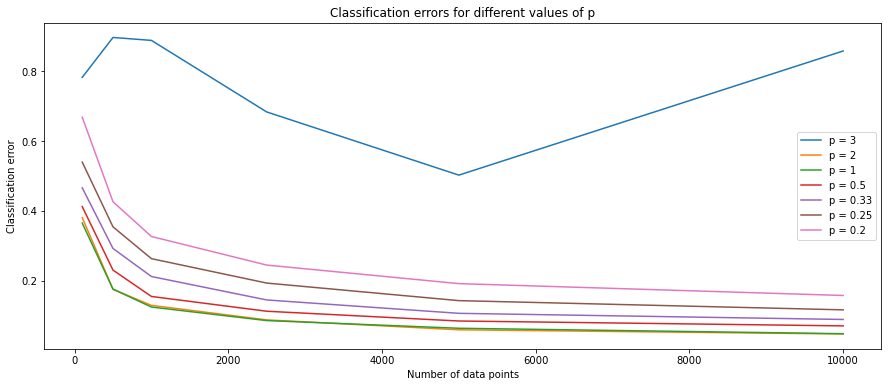

In [32]:
legend = []
fig, axes = plt.subplots(1, 1, figsize = (15, 6))
for p in p_list:
    axes.plot(data_list, errors[p])
    legend += [f'p = {round(p, 2)}']
axes.legend(legend)
axes.set_title('Classification errors for different values of p')
axes.set_xlabel('Number of data points')
_ = axes.set_ylabel('Classification error')

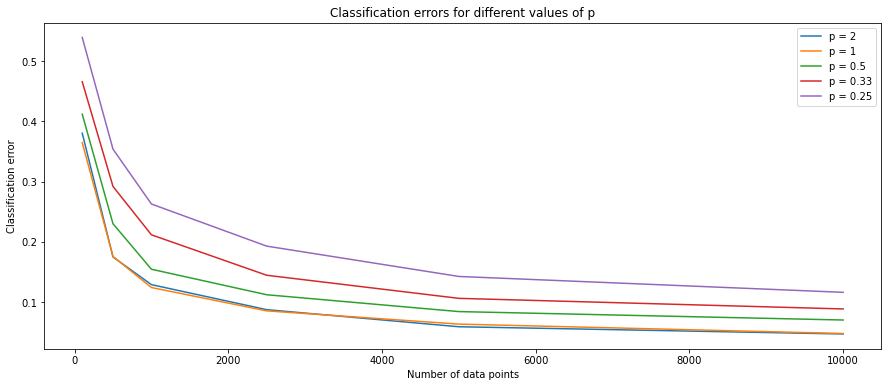

In [35]:
legend = []
fig, axes = plt.subplots(1, 1, figsize = (15, 6))
for p in p_list[1:-1]:
    axes.plot(data_list, errors[p])
    legend += [f'p = {round(p, 2)}']
axes.legend(legend)
axes.set_title('Classification errors for different values of p')
axes.set_xlabel('Number of data points')
_ = axes.set_ylabel('Classification error')

In [31]:
num_train = 10000
num_test = 2500
num_digits = 10

X_train, y_train, X_test, y_test = prepare_data(train_X, train_y, test_X, test_y, num_train, num_test, num_digits)

if os.path.exists('distance_matrix_train.pickle'):
    with open('distance_matrix_train.pickle', 'rb') as f:
        D = pickle.load(f)
else:
    D = distance_matrix(X_train, X_train)
    with open('distance_matrix_train.pickle', 'wb') as f:
        pickle.dump(D, f)

if os.path.exists('distance_matrix_test.pickle'):
    with open('distance_matrix_test.pickle', 'rb') as f:
        D_test = pickle.load(f)
else:
    D_test = distance_matrix(X_test, X_train)
    with open('distance_matrix_test.pickle', 'wb') as f:
        pickle.dump(D_test, f)

In [32]:
errors1 = {}
errors2 = {}
p_list = [1, 2]
c_list = [0.1, 1, 10, 100]
data_list = [100, 500, 1000, 2500, 5000, 10000]

for c in c_list:
    errors1[c] = []
    errors2[c] = []

for num_data in data_list:
    for c in c_list:
        for p in p_list:
            D1 = D[:num_data, :num_data]
            D_test1 = D_test[:, :num_data]

            K = kernel_func_p(D1, c * np.mean(D1), p)

            y_matrix = create_y_matrix(y_train[:num_data], num_digits)
            alpha = solve_alpha(K, y_matrix)

            K_test = kernel_func_p(D_test1, c * np.mean(D1), p)

            predictions = np.matmul(K_test, alpha)

            if p == 1:
                errors1[c] += [classification(predictions, y_test)]
            else:
                errors2[c] += [classification(predictions, y_test)]
                
            clear_output(True)
            print(f'Finished num_data = {num_data}, c = {c}, and p = {p}.')

Finished num_data = 10000, c = 100, and p = 2.


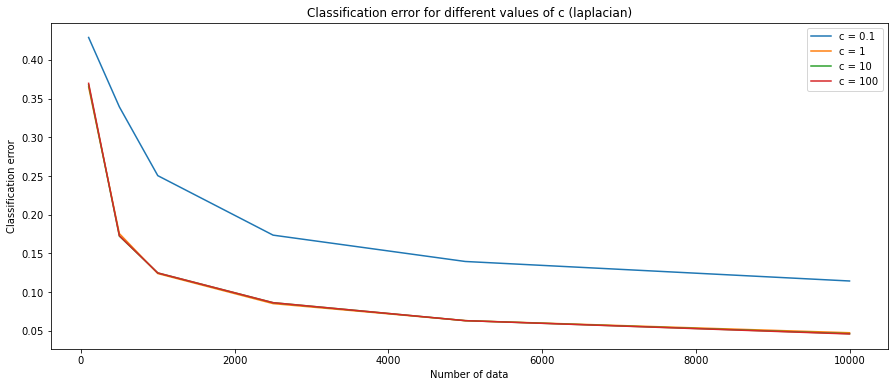

In [42]:
fig, axes = plt.subplots(1, 1, figsize = (15, 6))

legend = []
for c in c_list:
    axes.plot(data_list, errors1[c])
    legend += [f'c = {c}']
axes.legend(legend)
axes.set_title('Classification error for different values of c (laplacian)')
axes.set_xlabel('Number of data')
_ = axes.set_ylabel('Classification error')

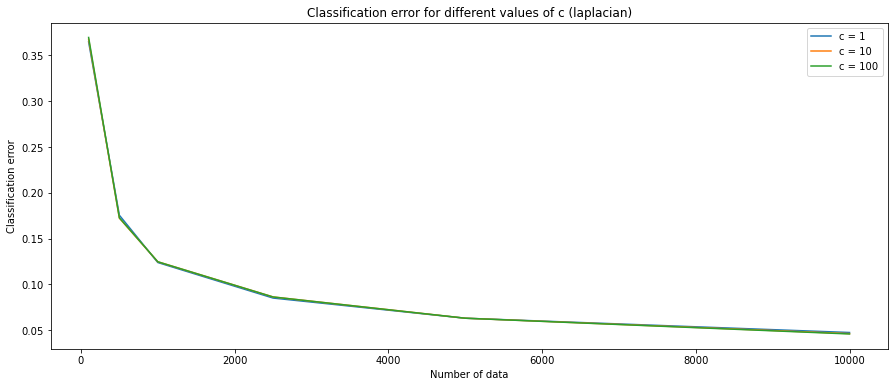

In [43]:
fig, axes = plt.subplots(1, 1, figsize = (15, 6))

legend = []
for c in c_list[1:]:
    axes.plot(data_list, errors1[c])
    legend += [f'c = {c}']
axes.legend(legend)
axes.set_title('Classification error for different values of c (laplacian)')
axes.set_xlabel('Number of data')
_ = axes.set_ylabel('Classification error')

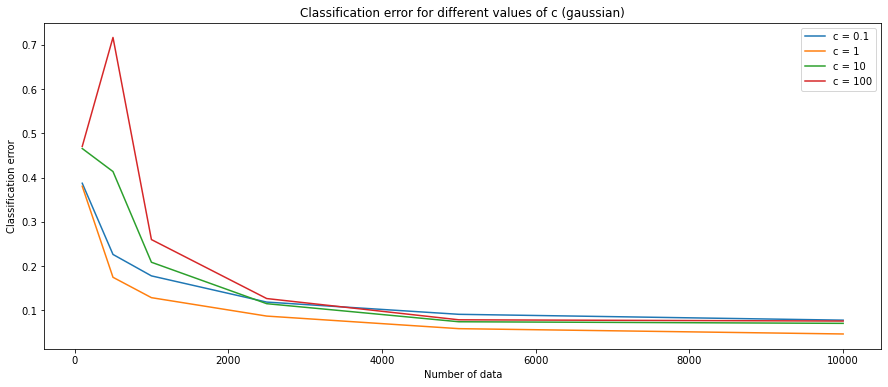

In [44]:
fig, axes = plt.subplots(1, 1, figsize = (15, 6))

legend = []
for c in c_list:
    axes.plot(data_list, errors2[c])
    legend += [f'c = {c}']
axes.legend(legend)
axes.set_title('Classification error for different values of c (gaussian)')
axes.set_xlabel('Number of data')
_ = axes.set_ylabel('Classification error')

In [6]:
num_train = 10000
num_test = 2500
num_digits = 10

X_train, y_train, X_test, y_test = prepare_data(train_X, train_y, test_X, test_y, num_train, num_test, num_digits)

if os.path.exists('distance_matrix_train.pickle'):
    with open('distance_matrix_train.pickle', 'rb') as f:
        D = pickle.load(f)
else:
    D = distance_matrix(X_train, X_train)
    with open('distance_matrix_train.pickle', 'wb') as f:
        pickle.dump(D, f)

if os.path.exists('distance_matrix_test.pickle'):
    with open('distance_matrix_test.pickle', 'rb') as f:
        D_test = pickle.load(f)
else:
    D_test = distance_matrix(X_test, X_train)
    with open('distance_matrix_test.pickle', 'wb') as f:
        pickle.dump(D_test, f)

In [4]:
def add_noise(y_train, p, num_digits):
    new_y = y_train.copy()
    to_change = np.random.choice(len(y_train), int(p * len(y_train)), replace = False)
    for index in to_change:
        new_y[index] = np.random.randint(num_digits)
    return new_y

In [15]:
K = kernel_func_p(D, np.mean(D), p = 2)
K_test = kernel_func_p(D_test, np.mean(D), p = 2)
K_inv = np.linalg.inv(K)

errors = []
noisiness = np.array(range(0, 95, 5)) / 100

for noise in noisiness:
    new_y = add_noise(y_train, noise)
    y_matrix = create_y_matrix(new_y, num_digits)
    alpha = np.matmul(K_inv, y_matrix)

    predictions = np.matmul(K_test, alpha)

    errors += [classification(predictions, y_test)]
    
    clear_output(True)
    print(f'Finished {noise * 100}% noise. Error = {errors[-1]}')

Finished 90.0% noise. Error = 0.8212


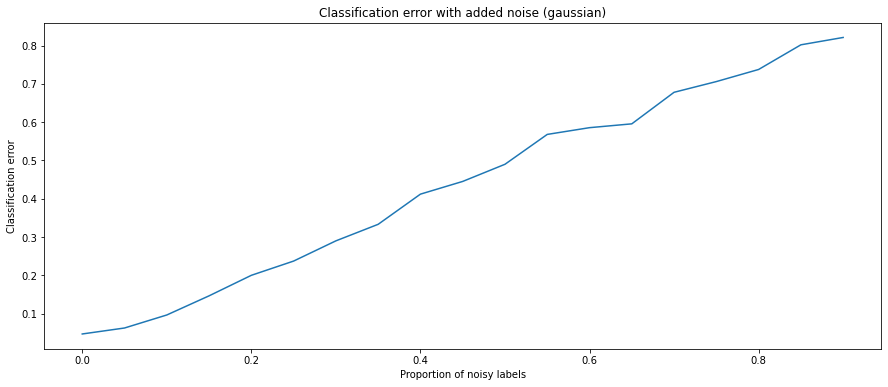

In [16]:
fig, axes = plt.subplots(1, 1, figsize = (15, 6))
axes.plot(noisiness, errors)
axes.set_title('Classification error with added noise (gaussian)')
axes.set_xlabel('Proportion of noisy labels')
_ = axes.set_ylabel('Classification error')

In [17]:
K = kernel_func_p(D, np.mean(D), p = 1)
K_test = kernel_func_p(D_test, np.mean(D), p = 1)
K_inv = np.linalg.inv(K)

errors = []
noisiness = np.array(range(0, 95, 5)) / 100

for noise in noisiness:
    new_y = add_noise(y_train, noise)
    y_matrix = create_y_matrix(new_y, num_digits)
    alpha = np.matmul(K_inv, y_matrix)

    predictions = np.matmul(K_test, alpha)

    errors += [classification(predictions, y_test)]
    
    clear_output(True)
    print(f'Finished {noise * 100}% noise. Error = {errors[-1]}')

Finished 90.0% noise. Error = 0.69


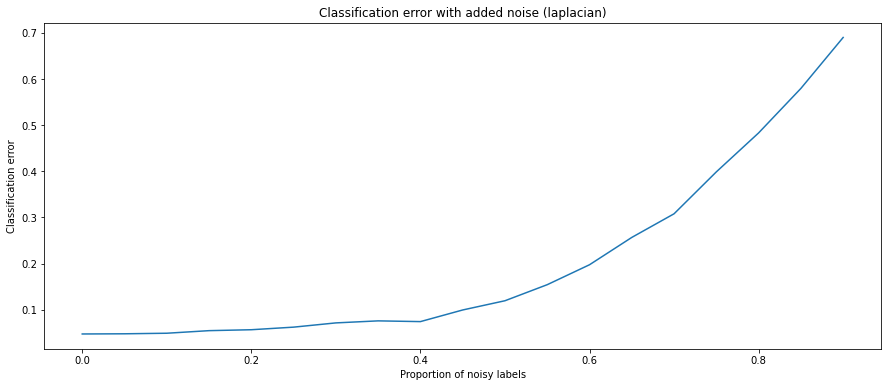

In [18]:
fig, axes = plt.subplots(1, 1, figsize = (15, 6))
axes.plot(noisiness, errors)
axes.set_title('Classification error with added noise (laplacian)')
axes.set_xlabel('Proportion of noisy labels')
_ = axes.set_ylabel('Classification error')

In [19]:
K = kernel_func_p(D, np.mean(D), p = 1/2)
K_test = kernel_func_p(D_test, np.mean(D), p = 1/2)
K_inv = np.linalg.inv(K)

errors = []
noisiness = np.array(range(0, 95, 5)) / 100

for noise in noisiness:
    new_y = add_noise(y_train, noise)
    y_matrix = create_y_matrix(new_y, num_digits)
    alpha = np.matmul(K_inv, y_matrix)

    predictions = np.matmul(K_test, alpha)

    errors += [classification(predictions, y_test)]
    
    clear_output(True)
    print(f'Finished {noise * 100}% noise. Error = {errors[-1]}')

Finished 90.0% noise. Error = 0.5880000000000001


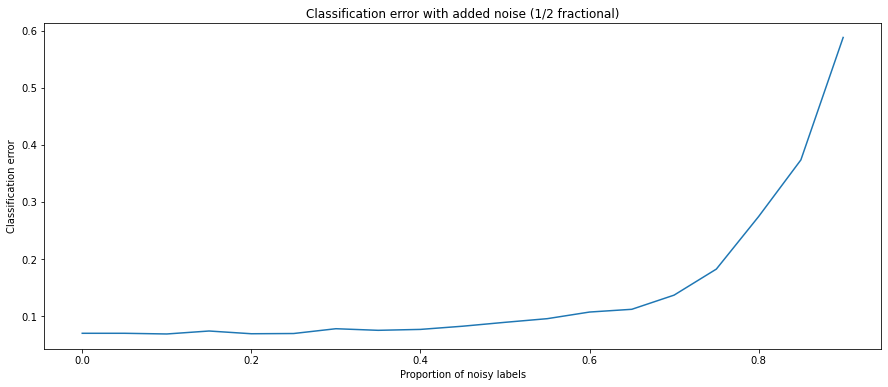

In [20]:
fig, axes = plt.subplots(1, 1, figsize = (15, 6))
axes.plot(noisiness, errors)
axes.set_title('Classification error with added noise (1/2 fractional)')
axes.set_xlabel('Proportion of noisy labels')
_ = axes.set_ylabel('Classification error')

In [21]:
K = kernel_func_p(D, np.mean(D), p = 1/3)
K_test = kernel_func_p(D_test, np.mean(D), p = 1/3)
K_inv = np.linalg.inv(K)

errors = []
noisiness = np.array(range(0, 95, 5)) / 100

for noise in noisiness:
    new_y = add_noise(y_train, noise)
    y_matrix = create_y_matrix(new_y, num_digits)
    alpha = np.matmul(K_inv, y_matrix)

    predictions = np.matmul(K_test, alpha)

    errors += [classification(predictions, y_test)]
    
    clear_output(True)
    print(f'Finished {noise * 100}% noise. Error = {errors[-1]}')

Finished 90.0% noise. Error = 0.392


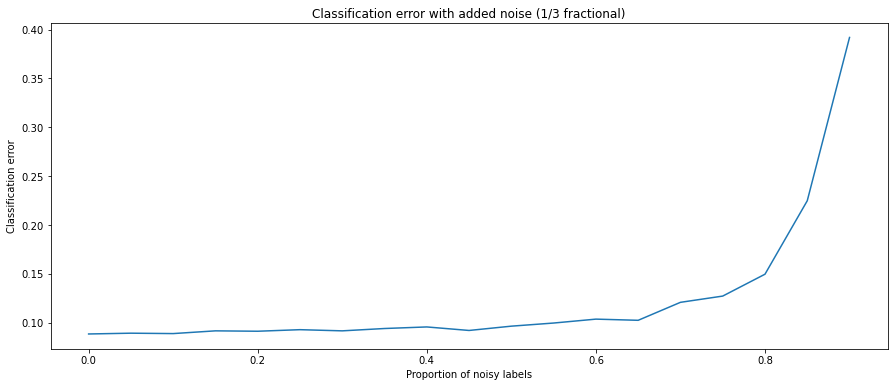

In [22]:
fig, axes = plt.subplots(1, 1, figsize = (15, 6))
axes.plot(noisiness, errors)
axes.set_title('Classification error with added noise (1/3 fractional)')
axes.set_xlabel('Proportion of noisy labels')
_ = axes.set_ylabel('Classification error')

In [25]:
K = kernel_func_p(D, np.mean(D), p = 1/4)
K_test = kernel_func_p(D_test, np.mean(D), p = 1/4)
K_inv = np.linalg.inv(K)

errors = []
noisiness = np.array(range(0, 95, 5)) / 100

for noise in noisiness:
    new_y = add_noise(y_train, noise)
    y_matrix = create_y_matrix(new_y, num_digits)
    alpha = np.matmul(K_inv, y_matrix)

    predictions = np.matmul(K_test, alpha)

    errors += [classification(predictions, y_test)]
    
    clear_output(True)
    print(f'Finished {noise * 100}% noise. Error = {errors[-1]}')

Finished 90.0% noise. Error = 0.26039999999999996


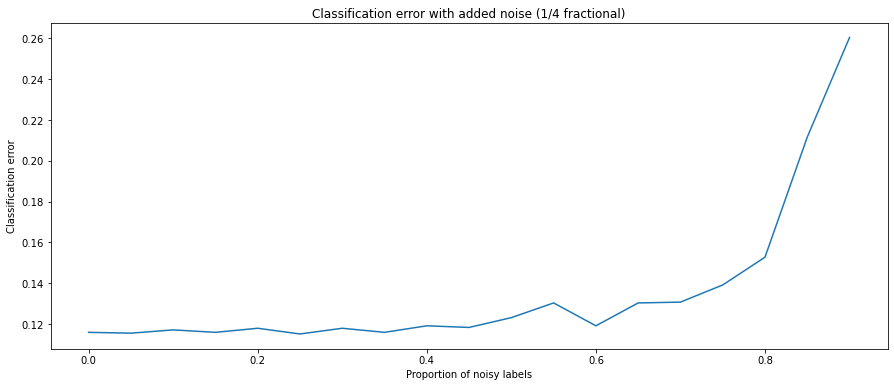

In [26]:
fig, axes = plt.subplots(1, 1, figsize = (15, 6))
axes.plot(noisiness, errors)
axes.set_title('Classification error with added noise (1/4 fractional)')
axes.set_xlabel('Proportion of noisy labels')
_ = axes.set_ylabel('Classification error')

In [27]:
K = kernel_func_p(D, np.mean(D), p = 1/5)
K_test = kernel_func_p(D_test, np.mean(D), p = 1/5)
K_inv = np.linalg.inv(K)

errors = []
noisiness = np.array(range(0, 95, 5)) / 100

for noise in noisiness:
    new_y = add_noise(y_train, noise)
    y_matrix = create_y_matrix(new_y, num_digits)
    alpha = np.matmul(K_inv, y_matrix)

    predictions = np.matmul(K_test, alpha)

    errors += [classification(predictions, y_test)]
    
    clear_output(True)
    print(f'Finished {noise * 100}% noise. Error = {errors[-1]}')

Finished 90.0% noise. Error = 0.29079999999999995


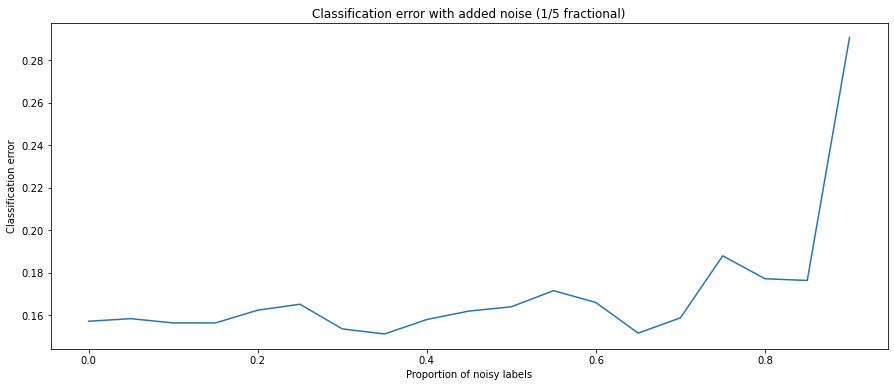

In [28]:
fig, axes = plt.subplots(1, 1, figsize = (15, 6))
axes.plot(noisiness, errors)
axes.set_title('Classification error with added noise (1/5 fractional)')
axes.set_xlabel('Proportion of noisy labels')
_ = axes.set_ylabel('Classification error')

In [29]:
K = kernel_func_p(D, np.mean(D), p = 1/6)
K_test = kernel_func_p(D_test, np.mean(D), p = 1/6)
K_inv = np.linalg.inv(K)

errors = []
noisiness = np.array(range(0, 95, 5)) / 100

for noise in noisiness:
    new_y = add_noise(y_train, noise)
    y_matrix = create_y_matrix(new_y, num_digits)
    alpha = np.matmul(K_inv, y_matrix)

    predictions = np.matmul(K_test, alpha)

    errors += [classification(predictions, y_test)]
    
    clear_output(True)
    print(f'Finished {noise * 100}% noise. Error = {errors[-1]}')

Finished 90.0% noise. Error = 0.32520000000000004


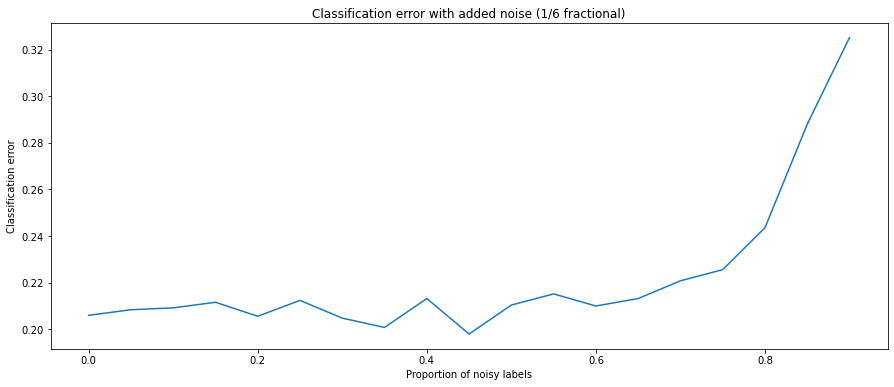

In [30]:
fig, axes = plt.subplots(1, 1, figsize = (15, 6))
axes.plot(noisiness, errors)
axes.set_title('Classification error with added noise (1/6 fractional)')
axes.set_xlabel('Proportion of noisy labels')
_ = axes.set_ylabel('Classification error')

In [16]:
X_train, y_train, X_test, y_test = prepare_data(train_X, train_y, test_X, test_y, num_train = 1000, num_test = 500, num_digits = 2)

In [17]:
D = distance_matrix(X_train, X_train)
D_test = distance_matrix(X_test, X_train)
K = kernel_func_p(D, np.mean(D))
K_test = kernel_func_p(D_test, np.mean(D))
y_matrix = create_y_matrix(y_train, 2)
alpha = solve_alpha(K, y_matrix)
predictions = np.matmul(K_test, alpha)
print(classification(predictions, y_test))

0.0


In [59]:
with open('train_X.pickle', 'rb') as f:
    train_X = pickle.load(f)
with open('train_y.pickle', 'rb') as f:
    train_y = pickle.load(f)
with open('test_X.pickle', 'rb') as f:
    test_X = pickle.load(f)
with open('test_y.pickle', 'rb') as f:
    test_y = pickle.load(f)
X_train, y_train, X_test, y_test = prepare_data(train_X, train_y, test_X, test_y, num_train = 1000, num_test = 500, num_digits = 2)

In [60]:
D = distance_matrix(X_train, X_train)
D_test = distance_matrix(X_test, X_train)
K = kernel_func_p(D, np.mean(D))
K_test = kernel_func_p(D_test, np.mean(D))
noisy_y = add_noise(y_train, 0.7, 2)
y_matrix = create_y_matrix(noisy_y, 2)
alpha = solve_alpha(K, y_matrix)
predictions = np.matmul(K_test, alpha)
print(classification(predictions, y_test))

0.17600000000000005


In [35]:
x = []
y = []
for i in range(len(test_y)):
    if test_y[i] in [0, 1]:
        x.append(test_X[i])
        y.append(test_y[i])
        
    if len(y) == 500:
        break

In [47]:
with open('test_X.pickle', 'wb') as f:
    pickle.dump(x, f)
with open('test_y.pickle', 'wb') as f:
    pickle.dump(y, f)

In [48]:
with open('test_X.pickle', 'rb') as f:
    temp = pickle.load(f)

In [49]:
temp

[array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,  38, 254, 109,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,  87, 252,  82,   0,   0,   0,   0,   0,   0,   0,
           0

In [7]:
with open('train_X.pickle', 'rb') as f:
    train_X = pickle.load(f)
with open('train_y.pickle', 'rb') as f:
    train_y = pickle.load(f)
with open('test_X.pickle', 'rb') as f:
    test_X = pickle.load(f)
with open('test_y.pickle', 'rb') as f:
    test_y = pickle.load(f)

# This will be changed later such that it is possible for
# different number of multi-class classification
# for now it will only work for 2 class classification
num_classes = 2
# num_classes = script_params['num_classes']

# prepare data
X_train, y_train, X_test, y_test = prepare_data(train_X, train_y, test_X, test_y, num_digits = num_classes)
results = {}

# setup distance matrices
D = distance_matrix(X_train, X_train)
D_test = distance_matrix(X_test, X_train)

# iterate through specified kernel types
for p in [1, 2]:
    results[p] = {}

    # Iterate through specified c modifiers
    for c in [1]:
        results[p][c] = []

        # setup kernel matrices
        K = kernel_func_p(D, c * np.mean(D), p)
        K_inv = np.linalg.inv(K)
        K_test = kernel_func_p(D_test, c * np.mean(D), p)

        # Iterate through noisiness levels
        for noise in np.arange(0, 0.9 + 0.05, 0.05):
            # randomly add noise to y
            noisy_y = add_noise(y_train, round(noise, 5), num_classes)

            # create noisy label matrix
            y_matrix = create_y_matrix(noisy_y, num_classes)

            # solve for alpha vector
            alpha = np.matmul(K_inv, y_matrix)

            # Create predictions and find classification error
            predictions = np.matmul(K_test, alpha)
            results[p][c].append(round(classification(predictions, y_test), 5))

In [8]:
results

{1: {1: [0.0,
   0.0,
   0.0,
   0.002,
   0.006,
   0.01,
   0.006,
   0.012,
   0.012,
   0.03,
   0.056,
   0.076,
   0.098,
   0.09,
   0.132,
   0.244,
   0.27,
   0.346,
   0.408]},
 2: {1: [0.002,
   0.026,
   0.074,
   0.108,
   0.144,
   0.144,
   0.16,
   0.202,
   0.202,
   0.27,
   0.308,
   0.304,
   0.316,
   0.372,
   0.41,
   0.376,
   0.454,
   0.414,
   0.496]}}

In [ ]:
with open('../out/results.json', 'r') as f:
    results = json.load(f)
    
with open('../config/script-params.json', 'r') as f:
    sp = json.load(f)

Text(0, 0.5, 'Classification error')

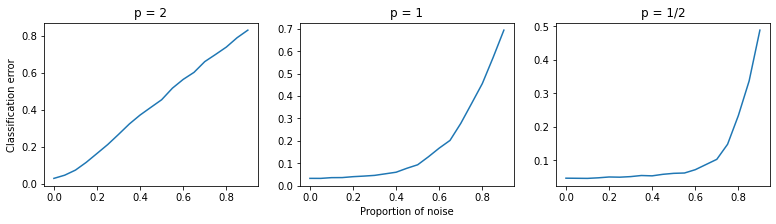

In [20]:
noisiness = np.arange(sp['min_noise'], sp['max_noise'] + sp['noise_step'], sp['noise_step'])

fig, axes = plt.subplots(1, 3, figsize = (13, 3))

axes[0].plot(noisiness, results['2']['1'])
axes[0].set_title('p = 2')
axes[1].plot(noisiness, results['1']['1'])
axes[1].set_title('p = 1')
axes[2].plot(noisiness, results['0.5']['1'])
axes[2].set_title('p = 1/2')

axes[1].set_xlabel('Proportion of noise')
axes[0].set_ylabel('Classification error')

Text(0, 0.5, 'Classification error')

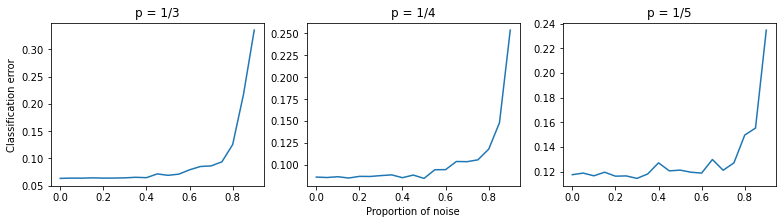

In [22]:
noisiness = np.arange(sp['min_noise'], sp['max_noise'] + sp['noise_step'], sp['noise_step'])

fig, axes = plt.subplots(1, 3, figsize = (13, 3))

axes[0].plot(noisiness, results['0.3333']['1'])
axes[0].set_title('p = 1/3')
axes[1].plot(noisiness, results['0.25']['1'])
axes[1].set_title('p = 1/4')
axes[2].plot(noisiness, results['0.2']['1'])
axes[2].set_title('p = 1/5')

axes[1].set_xlabel('Proportion of noise')
axes[0].set_ylabel('Classification error')

Text(0.5, 1.0, 'Noise vs. error for different kernels')

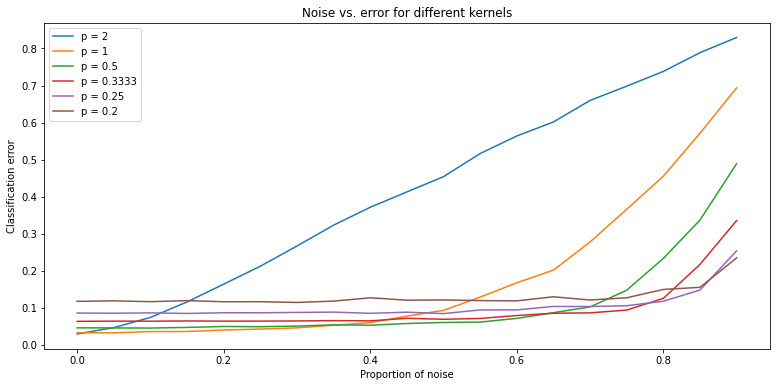

In [31]:
fig, axes = plt.subplots(figsize = (13, 6))

legend = []

for p in sp['p_kernels']:
    axes.plot(noisiness, results[str(p)]['1'])
    legend += [f'p = {p}']
    
axes.legend(legend)
axes.set_xlabel('Proportion of noise')
axes.set_ylabel('Classification error')
axes.set_title('Noise vs. error for different kernels')

In [27]:
sp['p_kernels']

[2, 1, 0.5, 0.3333, 0.25, 0.2]